In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ZIPPATH = '/content/drive/My Drive/Training [NEW]'

Mounted at /content/drive


In [ ]:
practice_file1 = '/content/drive/My Drive/Training [NEW]/p00_n1_NEW_X.npy'
p000X = np.load(practice_file1)
practice_file2 = '/content/drive/My Drive/Training [NEW]/p00_n1_NEW_y.npy'
p000y = np.load(practice_file2)
practice_file1 = '/content/drive/My Drive/Training [NEW]/p00_n2_NEW_X.npy'
p001X = np.load(practice_file1)
practice_file2 = '/content/drive/My Drive/Training [NEW]/p00_n2_NEW_y.npy'
p001y = np.load(practice_file2)
practice_file1 = '/content/drive/My Drive/Training [NEW]/p01_n1_NEW_X.npy'
p002X = np.load(practice_file1)
practice_file2 = '/content/drive/My Drive/Training [NEW]/p01_n1_NEW_y.npy'
p002y = np.load(practice_file2)
practice_file1 = '/content/drive/My Drive/Training [NEW]/p02_n1_NEW_X.npy'
p003X = np.load(practice_file1)
practice_file2 = '/content/drive/My Drive/Training [NEW]/p02_n1_NEW_y.npy'
p003y = np.load(practice_file2)
practice_file1 = '/content/drive/My Drive/Training [NEW]/p02_n2_NEW_X.npy'
p004X = np.load(practice_file1)
practice_file2 = '/content/drive/My Drive/Training [NEW]/p02_n2_NEW_y.npy'
p004y = np.load(practice_file2)
practice_file1 = '/content/drive/My Drive/Training [NEW]/p03_n1_NEW_X.npy'
p005X = np.load(practice_file1)
practice_file2 = '/content/drive/My Drive/Training [NEW]/p03_n1_NEW_y.npy'
p005y = np.load(practice_file2)
practice_file1 = '/content/drive/My Drive/Training [NEW]/p03_n2_NEW_X.npy'

p00X = np.concatenate((p000X, p001X, p002X, p003X, p004X, p005X), axis = 0)
p00y = np.concatenate((p000y, p001y, p002y, p003y, p004y, p005y), axis = 0)

# Load the data, put the X's and y's together, (y = x \beta + \epsilon, of course :P)

**Starting Out**

This was a very challenging problem to get started out with, especially for us who aren't too particularly experienced in data science. However, our team was so intrigued by this problem and its opportunities that we decided to pursue it. We decided it was best to start by getting some visuals on the different features and seeing the distribution of sleep stages for a certain person during a night.

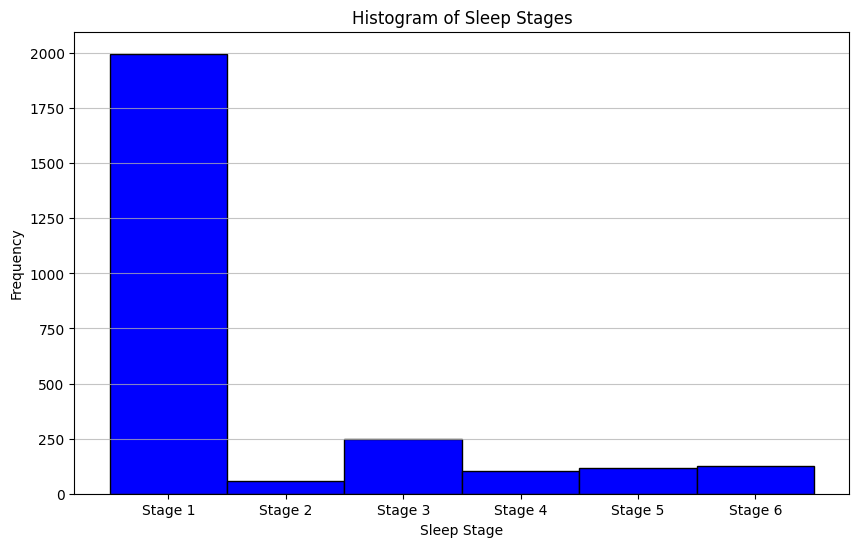

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(p000y, bins = np.arange(0.5, 7.5, 1), edgecolor='black', color='blue')

plt.xlabel('Sleep Stage')
plt.ylabel('Frequency')
plt.title('Histogram of Sleep Stages')
plt.xticks(ticks=np.arange(1, 7), labels=['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 5', 'Stage 6'])
plt.grid(axis='y', alpha=0.75)

plt.show()

As we can see from this histogram for Person 00 on Night 1, most of the time spent is in Stage 1, which is in the waking stage. Let's now investigate where it is timewise that the person is awake!

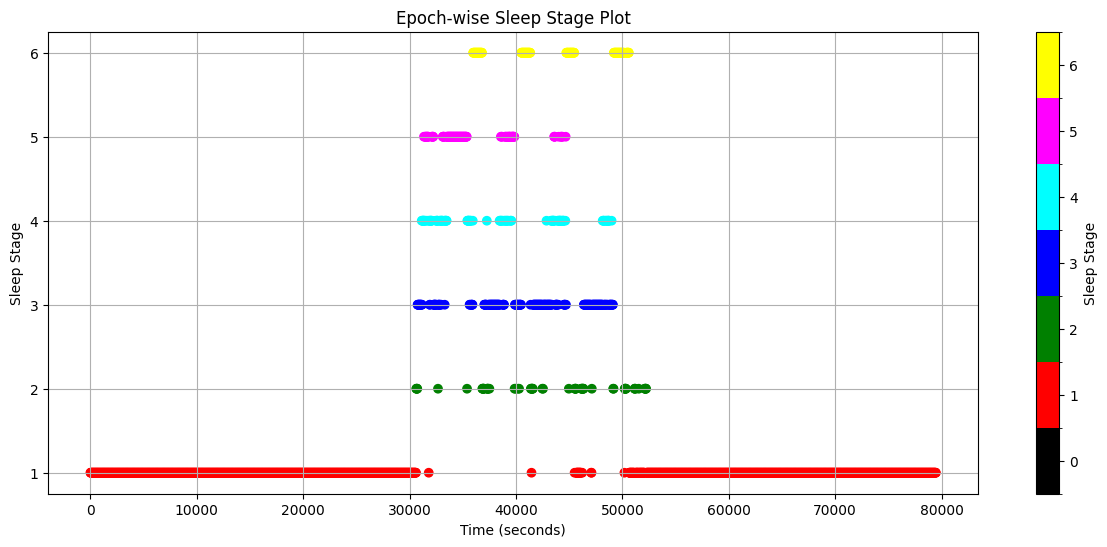

In [ ]:
# Define the total number of epochs and the duration of each epoch
num_epochs = len(p000y)
epoch_duration = 30  # seconds

# Create a time array representing each epoch
time = np.arange(0, num_epochs * epoch_duration, epoch_duration)

# Define color mapping for different sleep stages
colors = ['black', 'red', 'green', 'blue', 'cyan', 'magenta', 'yellow']
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(-0.5, 7, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create the plot
plt.figure(figsize=(15, 6))
plt.scatter(time, p000y, c=p000y, cmap=cmap, norm=norm)

# Create a colorbar with labels
cbar = plt.colorbar(ticks=np.arange(0, 7))
cbar.set_label('Sleep Stage')
cbar.set_ticklabels(['0', '1', '2', '3', '4', '5', '6'])  # Update with actual stage names if available

plt.xlabel('Time (seconds)')
plt.ylabel('Sleep Stage')
plt.title('Epoch-wise Sleep Stage Plot')
plt.grid(True)
plt.show()

As we can see from this plot, most of the time spent awake is at the beginning and end of the sleeping period, or we can say that it is before and after the sleeping period. When creating a model for classifying sleep stage, it will be important to remove the majority of these instances. Now, let's take a look at transitions between sleep stages!

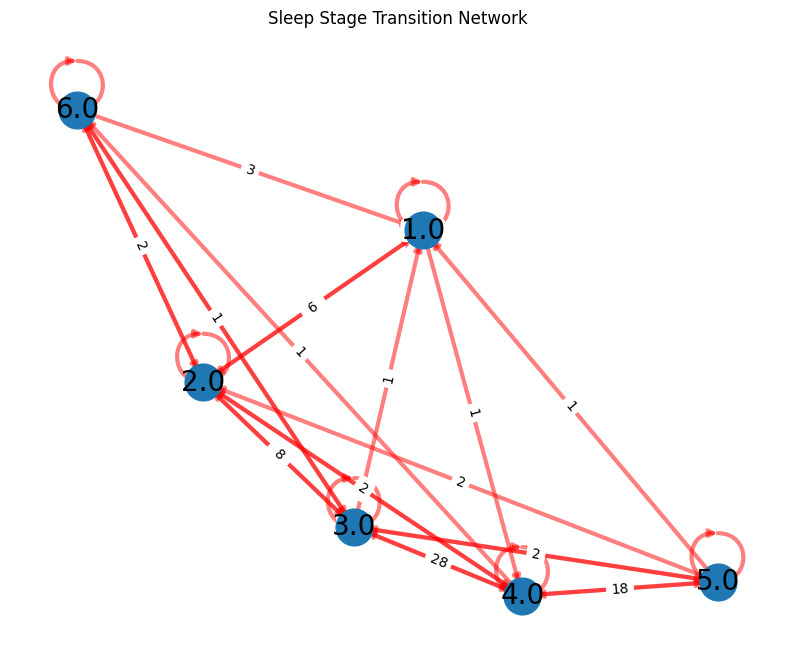

In [ ]:
# Calculate transitions
transitions = np.array([p000y[:-1], p000y[1:]]).T
unique_transitions, counts = np.unique(transitions, axis=0, return_counts=True)

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for (src, dst), count in zip(unique_transitions, counts):
    G.add_edge(src, dst, weight=count)

# Draw the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, width=3, alpha=0.5, edge_color='r')
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

# Display edge weights (transition counts)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title('Sleep Stage Transition Network')
plt.axis('off')
plt.show()

This graph shows the frequency that each sleeping stage transitions to another sleeping stage.  We see here that most frequent transitions happen between stages that are 1 stage apart, with the most frequent transition being between 3 and 4, which is the 2nd and 3rd stages of sleep. There are 3 transitions from REM sleep to wake . Oh no! One interesting thing about this problem is that yes, we may be classifying one epoch at a time, but the classification of this epic may be to an extent dependent on past epochs. The body doesn't necessarily make a full transition to a new stage in one epoch, which may be interesting to think about when considering constructing a model.

Let us now direct our attention to an analysis of the patterns of the 6 provided channels and get some ideas for more data visualization and feature engineering. We take a look at the data for Person 00 on Night 1 over all epochs and samples, while simultaneously plotting the sleep stage Person 00 is in. Note that we also remove the Waking phases pre- and post-sleep to focus on the relevant data at hand.

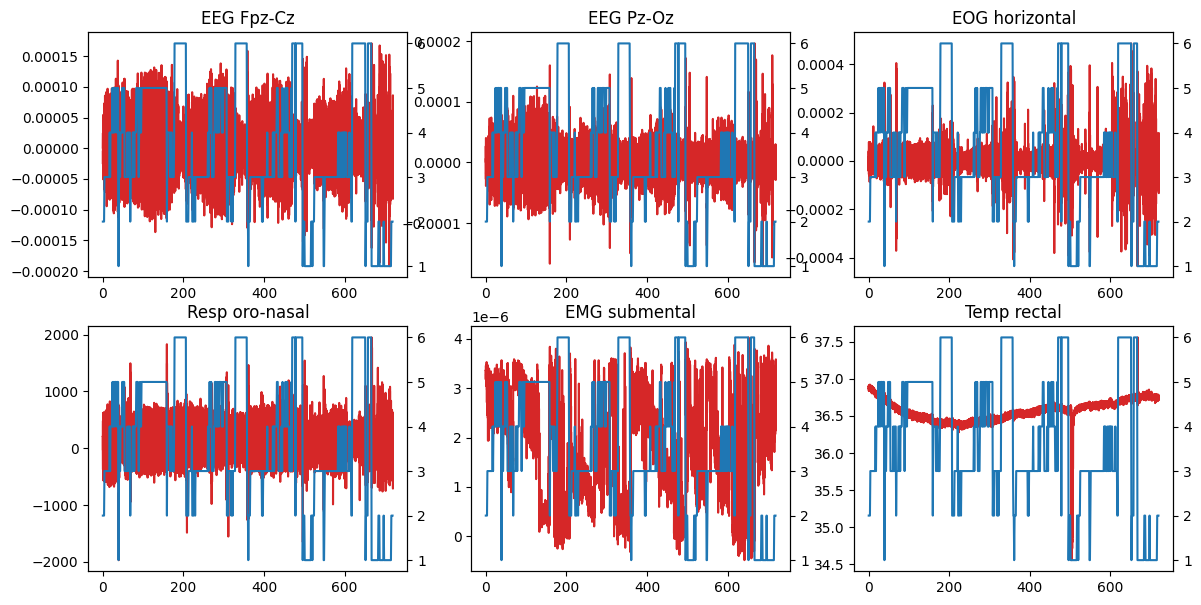

In [ ]:
channels = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal']

def remove_waking_phases(x_data: np.ndarray, y_data: np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Remove epochs labeled as waking phases at the start or end of the tracked time segment.

    Args:
        x_data: a raw (num epochs, num channels, num samples) array
        y_data: a raw num epochs-length vector

    Returns:
        the new X and y
    """
    last_presleep_epoch = 0
    for i in range(y_data.shape[0]):
        if y_data[i] != 1:
            last_presleep_epoch = i
            break

    first_postsleep_epoch = y_data.shape[0] - 1
    for i in range(y_data.shape[0] - 1, -1, -1):
        if y_data[i] != 1:
            first_postsleep_epoch = i
            break

    return x_data[last_presleep_epoch:first_postsleep_epoch, :, :], y_data[last_presleep_epoch:first_postsleep_epoch]

# remove pre- and post-sleep epochs labeled as waking phase
X, y = remove_waking_phases(p000X, p000y)

X_cont = np.hstack(X)

# plots of all signals and corresponding sleep stages for person 0, night 1
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 7))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
for ch, ax in enumerate(axes, 0):
    ax.plot(np.arange(0, y.shape[0], 0.01 / 30), X_cont[ch], color='tab:red')
    ax_prime = ax.twinx()
    ax_prime.plot(y, color='tab:blue')
    ax.title.set_text(channels[ch])
plt.show()

We notice some striking and certainly unique patterns in the data. The EMG submetal, for example, is similar to that of the Butterworth low-pass filter. The scales of each of the channels' data are also significantly different, implying a potential need for normalization during preprocessing. Furthermore, we confirm that the rectal temperature data is indeed relatively accurate with the y-axis representing degrees Celsius. With that in mind, let's do some more visualizations regarding popular transformations and filters applied to these signals. We start out with the two EEG signals and the EOG signal by applying a Fast Fourier Transformation (FFT) on them.

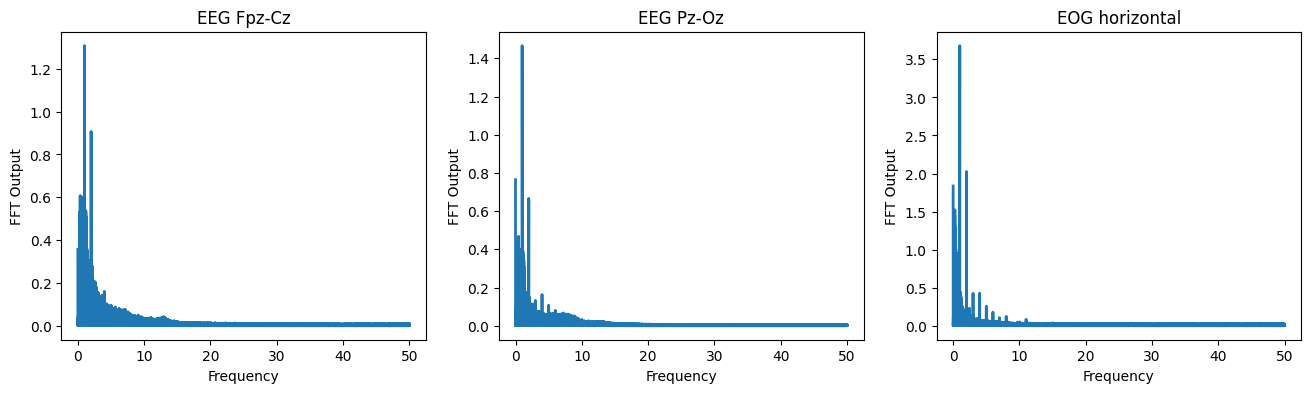

In [ ]:
from scipy.fft import rfft, rfftfreq

# FFTs on EEG FPz-Cz, EEG Pz-Oz, and EOG horizontal
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for ch in range(3):
    freq_data = rfftfreq(X_cont.shape[1], 0.01)
    fft_data = np.abs(rfft(X_cont[ch]))

    axes[ch].plot(freq_data, fft_data, linewidth=2, label=channels[ch])
    axes[ch].title.set_text(channels[ch])
    axes[ch].set_xlabel('Frequency')
    axes[ch].set_ylabel('FFT Output')
plt.show()

We've now transformed our data for these channels to be of log-normal distribution! While the FFT isn't perfect, it is one of the researched steps for feature engineering that significantly denoises the signals. We may then normalize the distribution again later on to work with the data for our models.

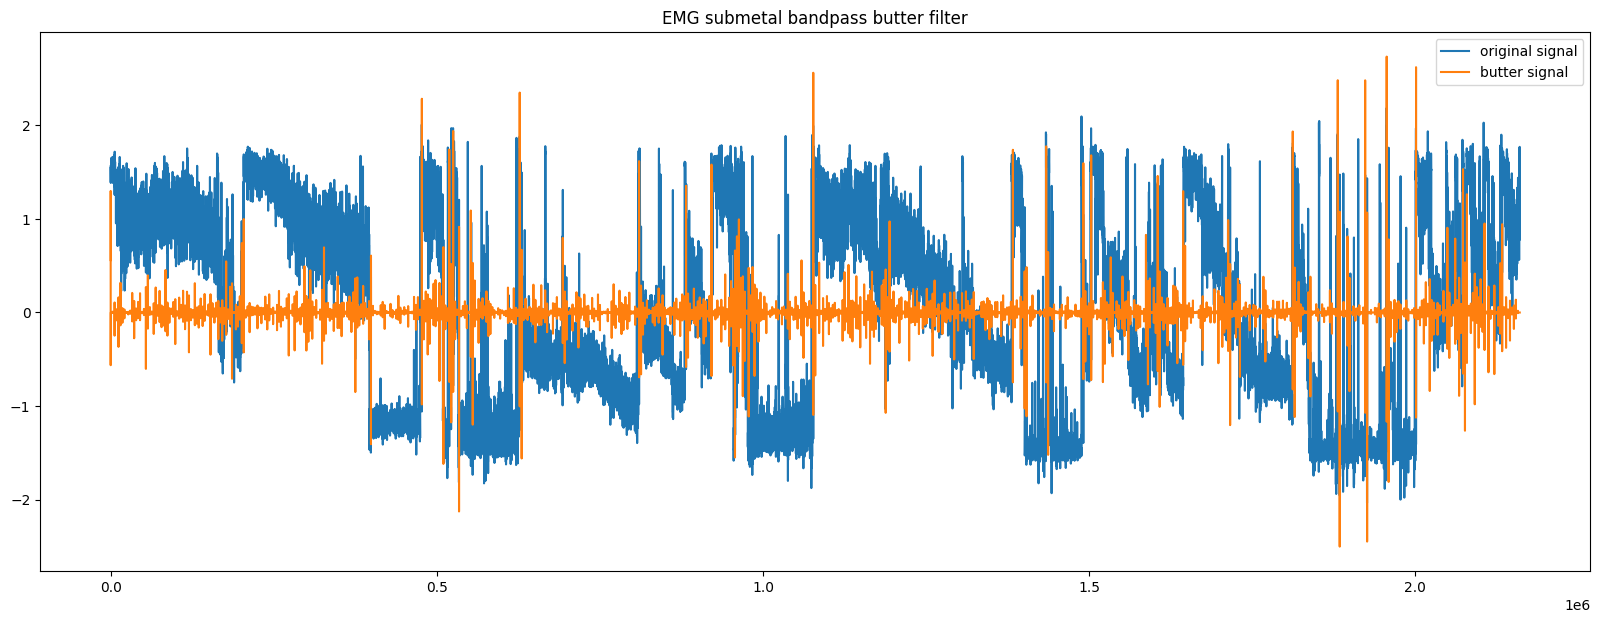

In [ ]:
from scipy.signal import butter, lfilter

# Butterworth on EMG submental
fig, ax = plt.subplots(figsize=(20, 7))
b, a = butter(N=4, Wn=[0.04, 0.8], btype='bandpass', analog=False, output='ba')
X_norm = (X_cont[4] - np.mean(X_cont[4])) / np.std(X_cont[4])
butter_filter = lfilter(b, a, X_norm)
ax.plot(X_norm, label='original signal')
ax.plot(butter_filter, label='butter signal')
ax.legend()
ax.title.set_text('EMG submetal bandpass butter filter')
plt.show()

Here we have a visualization of the EMG signal processed through a Butterworth bandpass filter. Bandpass is one of the popular types of filters along with low-pass used on EMG signals. Although this channel won't be used in some models directly like the CNN which only uses 3 RBG-represented channels, it's still cool :)

**LSTM Model for Classification**

The LSTM Model is a powerful recurrent neural network. It involves loops that allows information that it is learning from to "persist", making it capable of learning more long-term patterns. It includes a gate that is able to decide whether to keep a certain piece of information or forget it. Overall, its structure is great for the sleep stage classification problem because we aren't just classifying a data point based on just that data point: other data points are relevant to that classification, too.

In [ ]:
stage_1_indices = np.where(p00y == 1)[0]

# Randomly select 75% of these indices
num_to_remove = int(len(stage_1_indices) * 0.75)
indices_to_remove = np.random.choice(stage_1_indices, num_to_remove, replace=False)

# Create a mask that is True for all indices except those we want to remove
mask = np.ones(len(p00y), dtype=bool)
mask[indices_to_remove] = False

# Filter the data
p00X = p00X[mask]
p00y = p00y[mask]

X_norm = p00X/np.max(p00X)
y_categorical = to_categorical(p00y)

model = Sequential()
model.add(LSTM(75, return_sequences=True, input_shape=(X_norm.shape[1], X_norm.shape[2])))
model.add(LSTM(50))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_norm, y_categorical, test_size=0.1, random_state=1)

modelLSTM = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

val_loss, val_acc = model.evaluate(X_val, y_val)
print(val_loss, val_acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 75)             922800    
                                                                 
 lstm_1 (LSTM)               (None, 50)                25200     
                                                                 
 dense (Dense)               (None, 7)                 357       
                                                                 
Total params: 948357 (3.62 MB)
Trainable params: 948357 (3.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
226/226 [==============================] - 20s 61ms/step - loss: 1.0892 - accuracy: 0.6371 - val_loss: 0.9556 - val_accuracy: 0.6596
Epoch 2/5
226/226 [==============================] - 12s 53ms/step - loss: 0.9065 - accuracy: 0.6657 - val_loss: 0.9254 - val_accuracy: 0.662

26/26 [==============================] - 1s 20ms/step


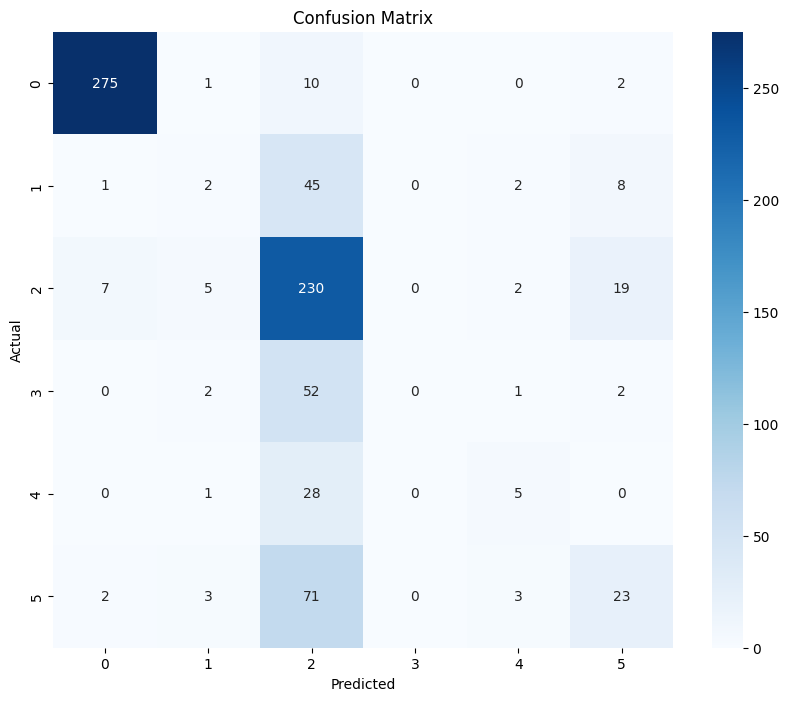

              precision    recall  f1-score   support

           1       0.96      0.95      0.96       288
           2       0.14      0.03      0.06        58
           3       0.53      0.87      0.66       263
           4       0.00      0.00      0.00        57
           5       0.38      0.15      0.21        34
           6       0.43      0.23      0.29       102

    accuracy                           0.67       802
   macro avg       0.41      0.37      0.36       802
weighted avg       0.60      0.67      0.61       802



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict the sleep stages on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes))

With some slight adjustments to the data provided and some tweaking of the LSTM model, we were able to get an okay performance with a validation accuracy of 56%. We decided to randomly remove 75% of the waking stages. We thought about removing most of the waking period that starts at the beginning and goes after the sleeping period but figured that it was most of the waking period anyway, and having a solid chunk of data on the waking period could be helpful in classifying it. Now, onto bigger and better things!

# Convolutional Neural Network Model

The convolutional neural network (CNN) is a widely used feed-forward network that can learn feature engineering on its own and make classification predictions. The relative structure of a CNN consists of convolutional layers that expand the number of channels while shrinking the input image size. The convolutional layers are sandwiched by activation function calls that update the status of neurons, as well as pooling layers which denoise the data. Finally, fully-connected or dense layers reduce the dimensionality until only the number of output classes remain.

For our case, we need to transform our data into workable images, specifically selecting 3 channels as the RGB values for the images. We choose the EEG FPz-Cz, EEG Pz-Oz, EOG horizontal signals, each of which were normalized then FFT'd. Each epoch of time comprises an image, and for the generation of square matrices as inputs to the CNN, a small portion of the 1501 samples (the 3000 samples were halved following the FFT transformations) were cut off.

**Model Structure**
Let's take a look at the model structure, which consists of just 2 convolutional/max-pooling layers and 3 fully-connected layers.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(16 * 6 * 6, 160)
        self.fc2 = nn.Linear(160, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

cnn = CNN()

**Training the Model**
We train the model by feeding in all epochs of data for different Persons and nights, of course setting some data aside for validation and testing.

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 4
NUM_EPOCHS = 2

def train_model(X_data: list, y_data: list):
    for X_fname, y_fname in zip(X_data, y_data):
        X = np.load("/content/drive/My Drive/Training [NEW]/" + X_fname)
        y = np.load("/content/drive/My Drive/Training [NEW]/" + y_fname)

        X, y = remove_waking_phases(X, y)
        X_cont = np.hstack(X)

        magnitude_spectrums = np.empty([0, 3, 3000])
        for ep in range(X.shape[0]):
            X_epoch = np.array([X_cont[ch, 0:3000] for ch in range(3)])
            X_epoch_norm = (X_epoch - np.mean(X_epoch, axis=1, keepdims=True)) / np.std(X_epoch, axis=1, keepdims=True)
            X_epoch_transformed = np.fft.fft2(X_epoch_norm)
            X_epoch_shifted = np.fft.fftshift(X_epoch_transformed)
            magnitude_spectrum = np.abs(X_epoch_shifted)
            magnitude_spectrum = X_epoch_norm
            magnitude_spectrum = np.reshape(magnitude_spectrum, (1, magnitude_spectrum.shape[0], -1))
            magnitude_spectrums = np.concatenate((magnitude_spectrums, magnitude_spectrum))

        X_epochs = magnitude_spectrums[:, 0:3, 0:1296]
        X_epochs_reshaped = np.reshape(X_epochs, (X_epochs.shape[0], 3, 36, -1))
        print(f'tensor size: {X_epochs_reshaped.shape}')
        X_train = torch.from_numpy(np.float32(X_epochs_reshaped))

        y_train = torch.from_numpy(y - 1)
        y_train = y_train.type(torch.LongTensor)

        trainset = TensorDataset(X_train, y_train)
        trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False)

        # model training
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(cnn.parameters(), lr=1e-4, momentum=0.9)

        for epoch in range(NUM_EPOCHS):

            running_loss = 0.0
            for batch, data in enumerate(trainloader, 0):
                features, labels = data
                optimizer.zero_grad()
                outputs = cnn(features)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print running loss
                running_loss += loss.item()
                if batch % 100 == 99:
                    print(f'[{epoch + 1}, {batch + 1:5d}] loss: {running_loss / 100:.3f}')
                    running_loss = 0.0

We can see that the data is first normalized with $\mu = 0$ and $\sigma = 1$, then 2-D discrete Fourier transformed. The epochs are then combined and reshaped to form a 4D PyTorch tensor that can be fed into the CNN. We create an aggregate PyTorch DataLoader object to make it easier to iterate through the dataset by batch size, and thus can account for different numbers of time epochs for different people on different nights.

**Validation Phase**
Now, we validate. Since we can't really "test" with the actual provided test files, but we can do our best to split our training set into training and validation parts to "validate" model performance.

In [ ]:
def validate_model(X_data, y_data):
    total_correct = 0
    total_epochs = 0

    for X_fname, y_fname in zip(X_data, y_data):
        X = np.load("/content/drive/My Drive/Training [NEW]/" + X_fname)
        y = np.load("/content/drive/My Drive/Training [NEW]/" + y_fname)

        X, y = remove_waking_phases(X, y)
        X_cont = np.hstack(X)

        magnitude_spectrums = np.empty([0, 3, 3000])
        for ep in range(X.shape[0]):
            X_epoch = np.array([X_cont[ch, 0:3000] for ch in range(3)])
            X_epoch_norm = (X_epoch - np.mean(X_epoch, axis=1, keepdims=True)) / np.std(X_epoch, axis=1, keepdims=True)
            X_epoch_transformed = np.fft.fft2(X_epoch_norm)
            X_epoch_shifted = np.fft.fftshift(X_epoch_transformed)
            magnitude_spectrum = np.abs(X_epoch_shifted)
            magnitude_spectrum = np.reshape(magnitude_spectrum, (1, magnitude_spectrum.shape[0], -1))
            magnitude_spectrums = np.concatenate((magnitude_spectrums, magnitude_spectrum))

        X_epochs = magnitude_spectrums[:, 0:3, 0:1296]
        print(f'X_epochs size: {X_epochs.shape}')
        X_epochs_reshaped = np.reshape(X_epochs, (X_epochs.shape[0], 3, 36, -1))
        X_valid = torch.from_numpy(np.float32(X_epochs_reshaped))

        y_valid = torch.from_numpy(y - 1)
        y_valid = y_valid.type(torch.LongTensor)

        validset = TensorDataset(X_valid, y_valid)
        validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

        with torch.no_grad():
            for data in validloader:
                features, labels = data
                outputs = cnn(features)
                _, predicted = torch.max(outputs.data, 1)  # softmax classification
                total_epochs += labels.size(0)
                total_correct += (predicted == labels).sum().item()

    print(f'Validation accuracy: {float(total_correct / total_epochs)}')

Now's let's actually train and validate our model with some data!

In [ ]:
# use different structure from LSTMs since waking phases are removed, leading to uneven number of epochs per file
X_train = ["p0" + str(i) + "_n1_NEW_X.npy" for i in range(2, 5)] + ["p0" + str(i) + "_n2_NEW_X.npy" for i in range(2, 5)]
y_train = ["p0" + str(i) + "_n1_NEW_y.npy" for i in range(2, 5)] + ["p0" + str(i) + "_n2_NEW_y.npy" for i in range(2, 5)]
train_model(X_train, y_train)

X_valid = ["p05_n1_NEW_X.npy", "p05_n2_NEW_X.npy"]
y_valid = ["p05_n1_NEW_y.npy", "p05_n2_NEW_y.npy"]
validate_model(X_valid, y_valid)

tensor size: (904, 3, 36, 36)
[1,   100] loss: 1.746
[1,   200] loss: 1.685
[2,   100] loss: 1.534
[2,   200] loss: 1.387
tensor size: (831, 3, 36, 36)
[1,   100] loss: 1.211
[1,   200] loss: 1.329
[2,   100] loss: 1.206
[2,   200] loss: 1.191
tensor size: (1115, 3, 36, 36)
[1,   100] loss: 1.348
[1,   200] loss: 1.183
[2,   100] loss: 1.323
[2,   200] loss: 1.171
tensor size: (889, 3, 36, 36)
[1,   100] loss: 1.633
[1,   200] loss: 1.287
[2,   100] loss: 1.624
[2,   200] loss: 1.280
tensor size: (790, 3, 36, 36)
[1,   100] loss: 1.638
[2,   100] loss: 1.547
tensor size: (1083, 3, 36, 36)
[1,   100] loss: 1.719
[1,   200] loss: 1.253
[2,   100] loss: 1.760
[2,   200] loss: 1.235
X_epochs size: (551, 3, 1296)
X_epochs size: (1127, 3, 1296)
Validation accuracy: 0.4862932061978546


Through multiple iterations, we notice a consistent 50% validation accuracy, which obviously isn't ideal but is solid enough to beat random chance by three-fold. The model experiences the challenge of possible overfitting with fluctuating training loss but can definitely be improved, especially if given more data or with exploring methods with different model structure, or feature engineering including PCA.

# Feature Engineering

We realized that the EEG brain wave data are signals, and thus passing those channels into the model as scalars feels wasteful. We looked into multiple ways to process signals, deciding that some type of Fourier Transform would allow us to pick out important frequencies.

The general distinct frequencies of brain waves are:
- Delta (0.5-4 Hz)
- Theta (4-8 Hz)
- Alpha (8-12 Hz)
- Beta (12-30 Hz)
- Gamma (30-40 Hz)

And from intro psychology, different stages of sleep tend to have different brain wave patterns!

In this next section we will extract and use the powers of distinct brain waves as features over time.


## Prologue
Your daily dose of python imports and utility functions

In [ ]:
import glob
import sys
import time
import joblib
!pip install mne
import mne
import matplotlib.pyplot as plt
import numpy as np

from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def progressbar(it, prefix="", size=60, out=sys.stdout): # Python3.6+
    count = len(it)
    start = time.time()
    def show(j):
        x = int(size*j/count)
        remaining = ((time.time() - start) / j) * (count - j)

        mins, sec = divmod(remaining, 60)
        time_str = f"{int(mins):02}:{sec:05.2f}"

        print(f"{prefix}[{u'█'*x}{('.'*(size-x))}] {j}/{count} Est wait {time_str}", end='\r', flush=True)

    for i, item in enumerate(it):
        yield item
        show(i+1)

    print("", flush=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 15.8 MB/s eta 0:00:00


## Data Wrangling

This function gets a single person's data and returns the features.

As every sample in an epoch will ultimatly be "combined" into one feature vector for that epoch, we give the option to split into sub epochs for temporal training.

If sub epochs are not requested the output data is of the shape _(epochs, features)_

If a number of sub epochs are specified the data is shaped as _(epochs, sub epochs, features)_

The features are:
- (0-1)   mean of both EEG channels
- (2-3)   std of both EEG channels
- (4-5)   power of delta band of both EEG channels (0.5-4 Hz)
- (6-7)   power of theta band of both EEG channels (4-8 Hz)
- (8-9)   power of alpha band of both EEG channels (8-12 Hz)
- (10-11) power of beta band of both EEG channels  (12-30 Hz)
- (12-13) power of gamma band of both EEG channels (30-40 Hz)

### Note:
*Many Many Many* other ways of cleaning and extracting the data were tried before this, mostly involving throwing random scipy functions before and after an FFT and hopeing something worked. We postulated an FFT was the way to go from the start, but cleaning these signals is no easy task and ended up taking most of our time.

The **mne** library ended up being a godsend, and we learned about it from and used [this notebook](https://colab.research.google.com/drive/1gm7xVYwEkqcOaDDUCQBtHOBHyvGt1HH2) as reference.

In [ ]:
def wrangle_data(person, SUB_EPOCHS=1):
    channels = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal']

    # Load the data
    X_raw= np.load(f"{person}_X.npy")
    y_raw = np.load(f"{person}_y.npy")

    # load the data into an mne object
    ch_types = ['eeg', 'eeg', 'eog', 'ecg', 'misc', 'misc']
    ch_names = channels
    sfreq = 100
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types, verbose=False)
    raw = mne.io.RawArray(np.hstack(X_raw), info, verbose=False)

    # rename the channels
    rename_dict = {
        'EEG Fpz-Cz': 'Fz',
        'EEG Pz-Oz': 'Pz',
        'EOG horizontal': 'eog',
        'Resp oro-nasal': 'ecg',
        'EMG submental': 'misc2',
        'Temp rectal': 'misc3'
    }
    raw.rename_channels(rename_dict, verbose=False)

    # set the montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, verbose=False)
    num_eeg_channels = len(mne.pick_types(raw.info, meg=False, eeg=True))

    # DEBUG
    # print(raw.info)
    # raw.plot()

    # filter the data
    raw.filter(1., 40., verbose=False)

    # artifact removal
    ica = mne.preprocessing.ICA(n_components=num_eeg_channels, random_state=97, max_iter=800, verbose=False)
    ica.fit(raw, verbose=False)

    # epoch the data
    # epoch into 30 second epochs (or the correct subepochs)
    events = mne.make_fixed_length_events(raw, duration= (30 / SUB_EPOCHS))
    epochs = mne.Epochs(raw, events=events, tmin=0., tmax=30., verbose=False, baseline=(0, 0))
    epochs.apply_baseline((0, 0), verbose=False)

    # comiple the features into a numpy array of ((sub)epochs, features)

    X = np.zeros((epochs.get_data(verbose = False).shape[0], 14))

    # compute the features for each epoch
    # epochs.get_data() has shape (epochs, channels, samples)
    for i, epoch in enumerate(epochs.get_data(verbose = False)):
        # mean of both channels
        X[i][0] = np.mean(epoch[0, :])
        X[i][1] = np.mean(epoch[1, :])

        # std of both channels
        X[i][2] = np.std(epoch[0, :])
        X[i][3] = np.std(epoch[1, :])

        # sfft of both channels
        f, t, Zxx = signal.stft(epoch, fs=raw.info['sfreq'])

        # power of delta band of both channels (0.5-4 Hz)
        delta_indices = np.where(np.logical_and(f >= 0.5, f <= 4))
        X[i][4] = np.sum(np.abs(Zxx[0, delta_indices, :]))
        X[i][5] = np.sum(np.abs(Zxx[1, delta_indices, :]))

        # power of theta band of both channels (4-8 Hz)
        theta_indices = np.where(np.logical_and(f >= 4, f <= 8))
        X[i][6] = np.sum(np.abs(Zxx[0, theta_indices, :]))
        X[i][7] = np.sum(np.abs(Zxx[1, theta_indices, :]))

        # power of alpha band of both channels (8-12 Hz)
        alpha_indices = np.where(np.logical_and(f >= 8, f <= 12))
        X[i][8] = np.sum(np.abs(Zxx[0, alpha_indices, :]))
        X[i][9] = np.sum(np.abs(Zxx[1, alpha_indices, :]))

        # power of beta band of both channels (12-30 Hz)
        beta_indices = np.where(np.logical_and(f >= 12, f <= 30))
        X[i][10] = np.sum(np.abs(Zxx[0, beta_indices, :]))
        X[i][11] = np.sum(np.abs(Zxx[1, beta_indices, :]))

        # power of gamma band of both channels (30-40 Hz)
        gamma_indices = np.where(np.logical_and(f >= 30, f <= 40))
        X[i][12] = np.sum(np.abs(Zxx[0, gamma_indices, :]))
        X[i][13] = np.sum(np.abs(Zxx[1, gamma_indices, :]))

    labels = ["mean Fz", "mean Pz", "std Fz", "std Pz", "delta Fz", "delta Pz", "theta Fz", "theta Pz", "alpha Fz", "alpha Pz", "beta Fz", "beta Pz", "gamma Fz", "gamma Pz"]

    # standardize the data, different people may have stronger brain waves but we just care about relativeness
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if SUB_EPOCHS > 1:
        #regroup sub epochs into epochs if needed
        X = np.reshape(X, (X.shape[0] // SUB_EPOCHS, SUB_EPOCHS, X.shape[1]))

    return X, y_raw[:-1], labels

## Epoch-wise analysis
When we treat whole epochs as time blocks we loose temporal data inside that epoch, but as a tradeoff the signal transformations tend to be more accurate, as they have more data to work with. This is also the simplest model to reason about and works quite well.

### Get the data

In [ ]:
# get all files in the Training directory
people = ['/content/drive/My Drive/Training [NEW]/p18_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p19_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p02_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p01_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p05_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p14_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p17_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p22_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p21_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p16_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p15_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p12_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p07_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p04_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p00_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p03_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p20_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p23_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p17_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p02_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p05_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p21_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p22_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p04_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p03_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p00_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p15_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p16_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p12_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p18_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p19_n2_NEW_X.npy']
people = [p[:-6] for p in people]

# load and concatinate all data (this takes a while on colab, so we will only load the first 5 here)
X, y, labels = None, None, None
for person in progressbar(people[:5], prefix="Processing people: "):
    X_temp, y_temp, labels_temp = wrangle_data(person)
    if X is None:
        X = X_temp
        y = y_temp
        labels = labels_temp
    else:
        X = np.concatenate((X, X_temp), axis=0)
        y = np.concatenate((y, y_temp), axis=0)

### Plot the features against the hypnogram

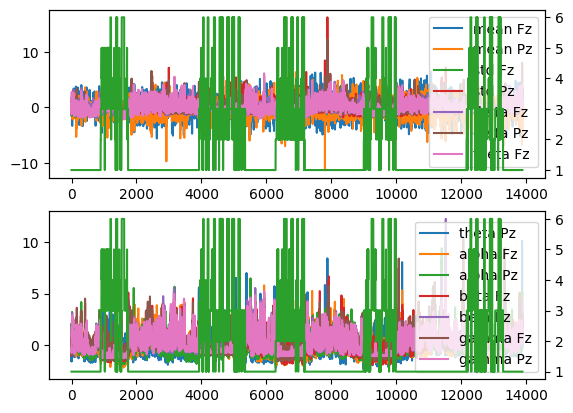

In [ ]:
fig, axs = plt.subplots(2, 1)
for ch in range(2):
     for f in range(7):
         axs[ch].plot(np.arange(0, X.shape[0]), X[:, ch*7 + f], label=labels[ch*7 + f])

     yxs = axs[ch].twinx()
     yxs.plot(y, color='tab:green')

     axs[ch].legend()

plt.show()

### Train a model
Just using a deep network here, didn't really have time to experiment much but this works well. Run until validation loss starts increasing


In [ ]:
# split the data into training and testing sets
num_categories = 7
X_prime = X
y_prime = to_categorical(y, num_categories)

X_train, X_test, y_train, y_test = train_test_split(X_prime, y_prime, test_size=0.2)

# make a keras model

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_categories, activation='softmax')
])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2, callbacks=[early_stop])


Epoch 1/1000
278/278 [==============================] - 6s 15ms/step - loss: 0.4240 - accuracy: 0.8541 - val_loss: 0.3175 - val_accuracy: 0.8790
Epoch 2/1000
278/278 [==============================] - 5s 18ms/step - loss: 0.2656 - accuracy: 0.9016 - val_loss: 0.2556 - val_accuracy: 0.9159
Epoch 3/1000
278/278 [==============================] - 2s 7ms/step - loss: 0.2390 - accuracy: 0.9068 - val_loss: 0.2346 - val_accuracy: 0.9177
Epoch 4/1000
278/278 [==============================] - 2s 8ms/step - loss: 0.2210 - accuracy: 0.9157 - val_loss: 0.2585 - val_accuracy: 0.9123
Epoch 5/1000
278/278 [==============================] - 2s 7ms/step - loss: 0.2069 - accuracy: 0.9207 - val_loss: 0.2347 - val_accuracy: 0.9132
Epoch 6/1000
278/278 [==============================] - 2s 7ms/step - loss: 0.2034 - accuracy: 0.9243 - val_loss: 0.2302 - val_accuracy: 0.9190
Epoch 7/1000
278/278 [==============================] - 2s 7ms/step - loss: 0.1984 - accuracy: 0.9247 - val_loss: 0.2200 - val_accurac

### Evaluate
Pretty accurate even only using the EEG features

87/87 [==============================] - 0s 4ms/step - loss: 0.2204 - accuracy: 0.9208
Loss: 0.2204008251428604
Accuracy: 0.920806348323822
87/87 [==============================] - 1s 4ms/step


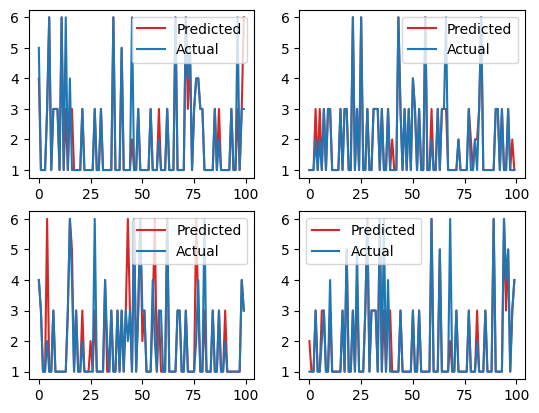

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

# make predictions and plot them against the actual data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

# Plot some random snippets of prediction vs real
fig, axs = plt.subplots(2, 2)
for ax in axs.flatten():
    rand = np.random.randint(0, len(y_test) - 100)
    ax.plot(y_pred[rand:rand+100], color='tab:red', label='Predicted')
    ax.plot(y_test[rand:rand+100], color='tab:blue', label='Actual')
    ax.legend()
plt.show()

## Intra-epoch analysis
If we get multiple feature vectors within an epoch, we can use that temporal data in classifying the entire epoch (or so is the idea). This is where we will try to usefancy things like CNNs and/or RNNs.

### Fetch the data
This time we wrangle into sub epochs

In [ ]:
# get all files in the Training directory
people = ['/content/drive/My Drive/Training [NEW]/p18_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p19_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p02_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p01_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p05_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p14_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p17_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p22_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p21_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p16_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p15_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p12_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p07_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p04_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p00_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p03_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p20_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p23_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p17_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p02_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p05_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p21_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p22_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p04_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p03_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p00_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p15_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p16_n1_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p12_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p18_n2_NEW_X.npy', '/content/drive/My Drive/Training [NEW]/p19_n2_NEW_X.npy']
people = [p[:-6] for p in people]

SUB_EPOCHS = 6

X, y, labels = None, None, None
for person in progressbar(people[:5], prefix="Processing people: "):
    X_temp, y_temp, labels_temp = wrangle_data(person, SUB_EPOCHS=SUB_EPOCHS)
    if X is None:
        X = X_temp
        y = y_temp
        labels = labels_temp
    else:
        X = np.concatenate((X, X_temp), axis=0)
        y = np.concatenate((y, y_temp), axis=0)

### Train the model
This time we use convolutional layers to pick out intra-epoch features and LSTM (Long Short-Term Model) layers to capture a temporal performance

In [ ]:
# split the data into training and testing sets
num_categories = 7
X_prime = X
y_prime = to_categorical(y, num_categories)

X_train, X_test, y_train, y_test = train_test_split(X_prime, y_prime, test_size=0.2)

# make a keras model

model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_categories, activation='softmax')
])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2, callbacks=[early_stop])


Epoch 1/1000
278/278 [==============================] - 10s 17ms/step - loss: 0.5697 - accuracy: 0.8151 - val_loss: 0.3158 - val_accuracy: 0.8844
Epoch 2/1000
278/278 [==============================] - 2s 8ms/step - loss: 0.3030 - accuracy: 0.8906 - val_loss: 0.2933 - val_accuracy: 0.8893
Epoch 3/1000
278/278 [==============================] - 2s 8ms/step - loss: 0.2681 - accuracy: 0.9044 - val_loss: 0.2567 - val_accuracy: 0.9087
Epoch 4/1000
278/278 [==============================] - 2s 7ms/step - loss: 0.2506 - accuracy: 0.9090 - val_loss: 0.2409 - val_accuracy: 0.9078
Epoch 5/1000
278/278 [==============================] - 2s 8ms/step - loss: 0.2360 - accuracy: 0.9116 - val_loss: 0.2353 - val_accuracy: 0.9141
Epoch 6/1000
278/278 [==============================] - 3s 10ms/step - loss: 0.2236 - accuracy: 0.9189 - val_loss: 0.2311 - val_accuracy: 0.9123
Epoch 7/1000
278/278 [==============================] - 3s 11ms/step - loss: 0.2132 - accuracy: 0.9224 - val_loss: 0.2388 - val_accur

### Evaluate
Performs well, could maybe be made better with fine tuning but not really a benifit over not using sub epochs

87/87 [==============================] - 1s 6ms/step - loss: 0.2208 - accuracy: 0.9240
Loss: 0.2208341658115387
Accuracy: 0.9240460991859436
87/87 [==============================] - 2s 4ms/step


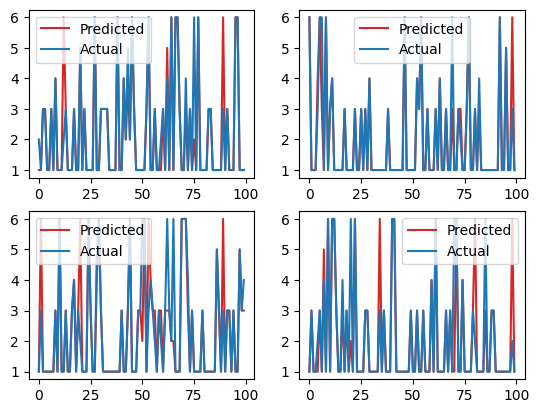

In [ ]:

loss, accuracy = model.evaluate(X_test, y_test)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

# make predictions and plot them against the actual data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

fig, axs = plt.subplots(2, 2)
for ax in axs.flatten():
    rand = np.random.randint(0, len(y_test) - 100)
    ax.plot(y_pred[rand:rand+100], color='tab:red', label='Predicted')
    ax.plot(y_test[rand:rand+100], color='tab:blue', label='Actual')
    ax.legend()

plt.show()

In [ ]:
# get all files in the Eval directory
people = glob.glob("Eval/*_NEW_X.npy")
people = [p[:-6] for p in people]
SUB_EPOCHS = 6
for person in progressbar(people, prefix="Processing people: "):
    X, _, _ = wrangle_data(person, SUB_EPOCHS=SUB_EPOCHS)

    # make predictions and plot them
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=1)

    # export the predictions to a npy file
    np.save(f"{person}.npy", y_pred)
# %%

eval code for prosperity
```python
# get all files in the Eval directory
people = glob.glob("Eval/*_NEW_X.npy")
people = [p[:-6] for p in people]
SUB_EPOCHS = 6
for person in progressbar(people, prefix="Processing people: "):
    X, _, _ = wrangle_data(person, SUB_EPOCHS=SUB_EPOCHS)

    # make predictions and plot them
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=1)

    # export the predictions to a npy file
    np.save(f"{person}.npy", y_pred)
# %%
```